# Curso de Especialista en Ciencia de Datos y Aplicaciones Escalables en la Nube II (CIDAEN)

## Trabajo final - Fernando Moreno Jabato


---

El siguiente documento contiene información sobre el trabajo final de D. Fernando Moreno Jabato para el Curso de Especialista en CIencia de Datos y Aplicaciones Escalables en la Nube (CIDAEN - Segunda edición).

## 1. El Proyecto

El proyecto consiste en la configuración y estudio de una Inteligencia Artificial (IA) basada en keras que aprenda a jugar al juego <a href="https://en.wikipedia.org/wiki/Snake_(video_game_genre)">Snake</a>, en concreto la versión clásica que no permite colisionar con las paredes. 

Para el desarrollo del mismo nos basaremos en el código por el usuario de github <a href="https://github.com/maurock">maurock</a> el cual ya es funcional y se encuentra en el siguiente <a href="https://github.com/maurock/snake-ga">repositorio</a>.

Vamos a modificar el código para que almacene diferente información sobre el aprendizaje del modelo así como para implementar diferentes configuraciones de redes neuronales para identificar cuál obtiene mejor rendimiento.

## 2. Código y depencias

El código base del que se parte pertence al usuario de github <a href="https://github.com/maurock">maurock</a> que está almacenado en el siguiente <a href="https://github.com/maurock/snake-ga">repositorio</a>.

Para el correcto funcionamiento de este código se necesita satisfacer las siguientes dependencias:
* **pygame:** permite crear entornos de vista de videojuegos así como simular escenarios basados en reglas (juegos).
* **random:** generación de modelos aleatorios.
* **numpy:** estructuras de datos.
* **keras:** gestor de modelos de machine learning.
* **matplotlib:** graficado.
* **seaborn:** graficado.
* **pandas:** estructuras de datos.
* **operator:** funciones eficientes de operaciones intrínsecas de Python.
* **time:** para obtener el tiempo del sistema

El código ha sido modificado para que no se ejecute direectamente utilizando la función `run()` de la clase principal `snakeClass`. Así mismo, algunos métodos serán sobrescritos en esta misma libreta de Jupyter para facilitar la gestión de las redes y dicho método principal será simulado en eesta libreta.

In [98]:
# Import necessary packages
import pygame
import random
import os
import time
from random import randint
from DQN import DQNAgent
from snakeClass import *
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import Embedding, LSTM
import pandas as pd
from operator import add

### 2.1 Estructura del código


## 3. Modificaciones del código
A continuación se detallan las modificaciones realizadas sobre el código:
* Se crea un nuevo main genérico que almacena las tuplas `{current_score,max_score}` así como los pesos de la red entrenada.
* Se modififca el código en el fichero `snakeClass.py` para evitar desplegar el visor del juego a menos que se solicite.
* Se incluyen métodos para medir el tiempo de ejcución de cada simulación.

**Nota:** Al utilizar el código original, se observan `warnings`por métodos obsoletos de la API de `Keras`. Estos métodos se mantendrán para respetar el código original del autor aunque la nueva versión de la API será utilizada para los modelos propios.

El nuevo main genérico creado es el siguiente:

In [99]:
'''
Function to execute a DQNAgent with snake game.
    Inputs:
        - agent : DQNAgent object (or child) to be executed
        - games : simulations to be performed
        - weights_file : output file where trained model nodes weights will be stored
        - verbose : boolean to activate verbose mode.
        - display_option: boolean to activate graphic UI to show simulations
    Outputs:
        - sim_scores : maximum score obtained in the simulation
        - sim_times : current simulation
'''
def run(agent = DQNAgent(),games = 150,weights_file = "weights.hdf5",verbose = False, display_option = False):
    # Initialize variables
    pygame.init()
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    #agent = DQNAgent()
    counter_games = 0
    sim_scores = []
    sim_times =[]
    record = 0
    if display_option:
        pygame.font.init()
        speed = 50
    # Simulate
    while counter_games < games:
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)
        
        # Time point
        start = time.time()
        
        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
                
        # Time point
        end = time.time()
        exec_time = end - start
        
        # Store game statistics
        agent.replay_new(agent.memory)
        counter_games += 1
        if verbose:
            print('Game', counter_games, '\tScore:', game.score, 'Time:', exec_time, '\tRecord:',record)
        sim_scores.append(game.score)
        sim_times.append(exec_time)
    agent.model.save_weights(weights_file)
    # Close display
    if display_option:
        pygame.font.quit()
    # return statistics
    return sim_scores, sim_times

C:\Users\FMJabato\OneDrive\Documentos\Estudios\003_Curso especialista Ciencia de Datos\Capstones\cs2-fmjabato-TFinal\Snake\DQN.py:79: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=11, units=120)`
  model.add(Dense(output_dim=120, activation='relu', input_dim=11))
C:\Users\FMJabato\OneDrive\Documentos\Estudios\003_Curso especialista Ciencia de Datos\Capstones\cs2-fmjabato-TFinal\Snake\DQN.py:81: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  model.add(Dense(output_dim=120, activation='relu'))
C:\Users\FMJabato\OneDrive\Documentos\Estudios\003_Curso especialista Ciencia de Datos\Capstones\cs2-fmjabato-TFinal\Snake\DQN.py:83: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  model.add(Dense(output_dim=120, activation='relu'))
C:\Users\FMJabato\OneDrive\Documentos\Estudios\003_Curso especialista Ciencia de Datos\Capstones\cs2-fmjabato-TFinal\Sna

### 3.1 Desactivación de código
Hay ciertas partes del código que tienen que ser desactivadas para poder ser re-implementadas en este trabajo. En concreto, la más importante es la anulación de la llamada a `run()`del script principal almacenado en `snakeClass.py`

### 3.2 Puntos de control


### 3.3 Modelo usado por la IA
El modelo usado por la IA es una red neuronal de Keras. El modelo base configurado por `maurock`consiste en una red con la siguiente disposición:
* Tres redes densas de 120 nodos con activación `ReLU` con un dropout con `ratio = 0.15`para cada una.
* Una red densa de 3 nodos como salida y activación tipo `Softmax`.
* Un optimizador tipo Adam con ratio de aprendizaje 0.0005 y una aproximación por _Mean Square Error (mse)_

Dicha red está guardada en el método `network`de la clase `DQN`. Para modificarlo vamos a proceder a crear clases herederas de ésta que sobrescriban el método de la red. Del mismo modo, si quisiéramos modificar alguno de los parámetros de configuración de la clase podríamos jugar con los siguientes:
self.reward = 0
* **gamma:** Default = 0.9
* **learning_rate:** Default = 0.0005

Aunque para modificar el `learning_rate vamos` a modificarlo directamente en la creación de las redes.

Vamos a ejecutar cinco redes:
1. (`Original`) Red original del repositorio.
2. (`Modified`) Red original del repositorio modificando las redes densas y el ratio de `dropout`
3. (`Pyramid`) Red de estructura piramidal manteniendo el número de `layers` pero incrementando su tamaño y asignando valores específicos de `dropout` a cada capa.
4. (`Pyramid_Low`) Misma estructura que `Pyramid` pero bajando el ratio de `dropout`.
5. (`LSTM`) Red tipo _Long Short-Term Memory_.

Para realizar las modificacione snecesitamos definir clases hija de la clase `DQNAgent`, que sobrescriban el método que devuelve la red del modelo (`network()`). Todas configuradas a continuación:

In [22]:
'''
Model Name : Modified
Changes performed:
    - Added nodes to all dense layers (less output dimension)
    - Modify Droput ratios
'''
class ModifiedDQNAgent(DQNAgent):
    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(180, activation='relu', input_dim = 11))
        model.add(Dropout(0.3))
        model.add(Dense(180, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(180, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(3, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)

        if weights:
            model.load_weights(weights)
        return model

In [25]:
'''
Model Name : Pyramid 
Changes performed:
    - Modified dense layers distribution (number_layers: equal; sizes: modified & not_shared)
    - Modify Droput ratios per layer
'''
class PyramidDQNAgent(DQNAgent):
    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(60, activation='relu', input_dim = 11))
        model.add(Dropout(0.15))
        model.add(Dense(120, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(240, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(3, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)

        if weights:
            model.load_weights(weights)
        return model

In [94]:
'''
Model Name : Pyramid_Low
Changes performed:
    - Modified dense layers distribution (number_layers: equal; sizes: modified & not_shared)
    - Modify Droput ratios per layer
'''
class PyramidLowDQNAgent(DQNAgent):
    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(60, activation='relu', input_dim = 11))
        model.add(Dropout(0.15))
        model.add(Dense(120, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(240, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(3, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)

        if weights:
            model.load_weights(weights)
        return model

In [95]:
'''
Model Name : LSTM (Long Short-Term Memory)
Changes performed:
    - Modified net structure
'''
class LSTMDQNAgent(DQNAgent):
    def network(self, weights=None):
        model = Sequential()
        model.add(Embedding(11, output_dim=256))
        model.add(LSTM(128))
        model.add(Dropout(0.3))
        model.add(Dense(3, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)

        if weights:
            model.load_weights(weights)
        return model

## 4. Prueba y estudio del código

### 4.1 Entrenamiento de la IA
A continuación se ejecutaran los modelos creados para su posterior comparación.

In [13]:
# Ejecución del código original
original_scores, original_times = run(games = 1000, weights_file = "original_weights.hdf5",verbose = True)

# Store/Load
np.save("original_scores", original_scores)
np.save("original_times", original_times)

Game 1 	Score: 1 Time: 0.2652909755706787 	Record: 1
Game 2 	Score: 0 Time: 0.08076810836791992 	Record: 1
Game 3 	Score: 1 Time: 0.08377599716186523 	Record: 1
Game 4 	Score: 1 Time: 0.11170196533203125 	Record: 1
Game 5 	Score: 0 Time: 0.27776575088500977 	Record: 1
Game 6 	Score: 0 Time: 0.08676767349243164 	Record: 1
Game 7 	Score: 1 Time: 0.16655540466308594 	Record: 1
Game 8 	Score: 2 Time: 0.5383546352386475 	Record: 2
Game 9 	Score: 2 Time: 0.12662220001220703 	Record: 2
Game 10 	Score: 1 Time: 0.05086183547973633 	Record: 2
Game 11 	Score: 2 Time: 0.0997314453125 	Record: 2
Game 12 	Score: 1 Time: 0.0468747615814209 	Record: 2
Game 13 	Score: 2 Time: 0.06183481216430664 	Record: 2
Game 14 	Score: 1 Time: 0.05968952178955078 	Record: 2
Game 15 	Score: 1 Time: 0.1406230926513672 	Record: 2
Game 16 	Score: 2 Time: 0.11668777465820312 	Record: 2
Game 17 	Score: 1 Time: 0.04288506507873535 	Record: 2
Game 18 	Score: 1 Time: 0.04686093330383301 	Record: 2
Game 19 	Score: 4 Time: 0.2

Game 149 	Score: 8 Time: 0.5496127605438232 	Record: 42
Game 150 	Score: 13 Time: 0.5285844802856445 	Record: 42
Game 151 	Score: 16 Time: 1.1047544479370117 	Record: 42
Game 152 	Score: 20 Time: 0.7458944320678711 	Record: 42
Game 153 	Score: 6 Time: 1.1814374923706055 	Record: 42
Game 154 	Score: 11 Time: 0.40192461013793945 	Record: 42
Game 155 	Score: 5 Time: 0.14959335327148438 	Record: 42
Game 156 	Score: 10 Time: 0.7245082855224609 	Record: 42
Game 157 	Score: 17 Time: 0.5945689678192139 	Record: 42
Game 158 	Score: 12 Time: 0.3590402603149414 	Record: 42
Game 159 	Score: 25 Time: 1.1254205703735352 	Record: 42
Game 160 	Score: 28 Time: 1.4150431156158447 	Record: 42
Game 161 	Score: 8 Time: 1.4675438404083252 	Record: 42
Game 162 	Score: 16 Time: 0.7491796016693115 	Record: 42
Game 163 	Score: 15 Time: 0.7011239528656006 	Record: 42
Game 164 	Score: 17 Time: 0.637606143951416 	Record: 42
Game 165 	Score: 24 Time: 1.0965344905853271 	Record: 42
Game 166 	Score: 20 Time: 1.236306

Game 294 	Score: 3 Time: 0.07878851890563965 	Record: 42
Game 295 	Score: 12 Time: 0.7639555931091309 	Record: 42
Game 296 	Score: 7 Time: 0.3351864814758301 	Record: 42
Game 297 	Score: 27 Time: 1.6725099086761475 	Record: 42
Game 298 	Score: 20 Time: 0.7827668190002441 	Record: 42
Game 299 	Score: 12 Time: 0.6423094272613525 	Record: 42
Game 300 	Score: 15 Time: 0.5738527774810791 	Record: 42
Game 301 	Score: 10 Time: 0.4228682518005371 	Record: 42
Game 302 	Score: 8 Time: 0.2762598991394043 	Record: 42
Game 303 	Score: 2 Time: 0.13862919807434082 	Record: 42
Game 304 	Score: 5 Time: 0.25439906120300293 	Record: 42
Game 305 	Score: 18 Time: 1.0586729049682617 	Record: 42
Game 306 	Score: 3 Time: 0.1535778045654297 	Record: 42
Game 307 	Score: 5 Time: 0.3044440746307373 	Record: 42
Game 308 	Score: 22 Time: 1.510571002960205 	Record: 42
Game 309 	Score: 17 Time: 0.532618522644043 	Record: 42
Game 310 	Score: 6 Time: 0.47072839736938477 	Record: 42
Game 311 	Score: 9 Time: 0.4713561534

Game 439 	Score: 21 Time: 1.1824426651000977 	Record: 42
Game 440 	Score: 10 Time: 0.39693641662597656 	Record: 42
Game 441 	Score: 17 Time: 0.8656678199768066 	Record: 42
Game 442 	Score: 14 Time: 0.8552875518798828 	Record: 42
Game 443 	Score: 15 Time: 0.49866557121276855 	Record: 42
Game 444 	Score: 5 Time: 0.11947154998779297 	Record: 42
Game 445 	Score: 13 Time: 0.5588893890380859 	Record: 42
Game 446 	Score: 6 Time: 0.20542168617248535 	Record: 42
Game 447 	Score: 12 Time: 0.6468105316162109 	Record: 42
Game 448 	Score: 11 Time: 0.4593660831451416 	Record: 42
Game 449 	Score: 23 Time: 1.3920402526855469 	Record: 42
Game 450 	Score: 13 Time: 0.7031183242797852 	Record: 42
Game 451 	Score: 7 Time: 0.2712738513946533 	Record: 42
Game 452 	Score: 2 Time: 0.06679034233093262 	Record: 42
Game 453 	Score: 12 Time: 0.5951063632965088 	Record: 42
Game 454 	Score: 25 Time: 1.323765754699707 	Record: 42
Game 455 	Score: 11 Time: 0.47186946868896484 	Record: 42
Game 456 	Score: 18 Time: 0.77

Game 584 	Score: 13 Time: 0.43560314178466797 	Record: 42
Game 585 	Score: 16 Time: 0.6321325302124023 	Record: 42
Game 586 	Score: 9 Time: 0.7078490257263184 	Record: 42
Game 587 	Score: 8 Time: 0.433840274810791 	Record: 42
Game 588 	Score: 4 Time: 0.18650174140930176 	Record: 42
Game 589 	Score: 11 Time: 0.7636547088623047 	Record: 42
Game 590 	Score: 10 Time: 0.5046443939208984 	Record: 42
Game 591 	Score: 6 Time: 0.3001673221588135 	Record: 42
Game 592 	Score: 10 Time: 0.7169210910797119 	Record: 42
Game 593 	Score: 5 Time: 0.4188504219055176 	Record: 42
Game 594 	Score: 11 Time: 0.4946761131286621 	Record: 42
Game 595 	Score: 36 Time: 1.9361400604248047 	Record: 42
Game 596 	Score: 11 Time: 0.3859679698944092 	Record: 42
Game 597 	Score: 11 Time: 0.35205864906311035 	Record: 42
Game 598 	Score: 15 Time: 0.7001259326934814 	Record: 42
Game 599 	Score: 9 Time: 0.3090250492095947 	Record: 42
Game 600 	Score: 10 Time: 0.32515788078308105 	Record: 42
Game 601 	Score: 7 Time: 0.3640270

Game 729 	Score: 13 Time: 0.48769521713256836 	Record: 42
Game 730 	Score: 13 Time: 0.5754318237304688 	Record: 42
Game 731 	Score: 5 Time: 0.16208696365356445 	Record: 42
Game 732 	Score: 7 Time: 0.2862284183502197 	Record: 42
Game 733 	Score: 4 Time: 0.28424692153930664 	Record: 42
Game 734 	Score: 9 Time: 0.5484507083892822 	Record: 42
Game 735 	Score: 13 Time: 0.4175760746002197 	Record: 42
Game 736 	Score: 7 Time: 0.3810875415802002 	Record: 42
Game 737 	Score: 3 Time: 0.06286120414733887 	Record: 42
Game 738 	Score: 20 Time: 0.9434328079223633 	Record: 42
Game 739 	Score: 10 Time: 0.4698481559753418 	Record: 42
Game 740 	Score: 3 Time: 0.10570502281188965 	Record: 42
Game 741 	Score: 10 Time: 0.9562606811523438 	Record: 42
Game 742 	Score: 5 Time: 0.20847606658935547 	Record: 42
Game 743 	Score: 8 Time: 0.4408254623413086 	Record: 42
Game 744 	Score: 21 Time: 1.1733415126800537 	Record: 42
Game 745 	Score: 8 Time: 0.49047207832336426 	Record: 42
Game 746 	Score: 11 Time: 0.486698

Game 874 	Score: 12 Time: 0.7167112827301025 	Record: 42
Game 875 	Score: 11 Time: 0.7061104774475098 	Record: 42
Game 876 	Score: 24 Time: 1.8978264331817627 	Record: 42
Game 877 	Score: 8 Time: 0.23296284675598145 	Record: 42
Game 878 	Score: 4 Time: 0.24380898475646973 	Record: 42
Game 879 	Score: 11 Time: 1.30485200881958 	Record: 42
Game 880 	Score: 15 Time: 0.6907694339752197 	Record: 42
Game 881 	Score: 3 Time: 0.21741747856140137 	Record: 42
Game 882 	Score: 18 Time: 1.4484279155731201 	Record: 42
Game 883 	Score: 25 Time: 1.2059004306793213 	Record: 42
Game 884 	Score: 3 Time: 0.17752528190612793 	Record: 42
Game 885 	Score: 27 Time: 1.4310016632080078 	Record: 42
Game 886 	Score: 23 Time: 1.086097002029419 	Record: 42
Game 887 	Score: 10 Time: 0.7179334163665771 	Record: 42
Game 888 	Score: 7 Time: 0.3370985984802246 	Record: 42
Game 889 	Score: 15 Time: 0.677342414855957 	Record: 42
Game 890 	Score: 19 Time: 1.1069376468658447 	Record: 42
Game 891 	Score: 5 Time: 0.254318714

In [27]:
# Ejecución del código original modificado en densidad
mod_scores, mod_times = run(agent = ModifiedDQNAgent(),games = 1000, weights_file = "mod_weights.hdf5",verbose = True)

# Store/Load
np.save("mod_scores", mod_scores)
np.save("mod_times", mod_times)

Game 1 	Score: 0 Time: 0.06482577323913574 	Record: 0
Game 2 	Score: 0 Time: 0.12218022346496582 	Record: 0
Game 3 	Score: 0 Time: 0.2483360767364502 	Record: 0
Game 4 	Score: 0 Time: 0.08377552032470703 	Record: 0
Game 5 	Score: 0 Time: 0.04856157302856445 	Record: 0
Game 6 	Score: 0 Time: 0.03291177749633789 	Record: 0
Game 7 	Score: 0 Time: 0.029915332794189453 	Record: 0
Game 8 	Score: 0 Time: 0.16155123710632324 	Record: 0
Game 9 	Score: 0 Time: 0.25729942321777344 	Record: 0
Game 10 	Score: 0 Time: 0.11962509155273438 	Record: 0
Game 11 	Score: 1 Time: 0.07679486274719238 	Record: 1
Game 12 	Score: 1 Time: 0.13442230224609375 	Record: 1
Game 13 	Score: 0 Time: 0.0967409610748291 	Record: 1
Game 14 	Score: 0 Time: 0.23337674140930176 	Record: 1
Game 15 	Score: 1 Time: 0.14261817932128906 	Record: 1
Game 16 	Score: 3 Time: 0.8314130306243896 	Record: 3
Game 17 	Score: 2 Time: 0.15358924865722656 	Record: 3
Game 18 	Score: 1 Time: 0.22838830947875977 	Record: 3
Game 19 	Score: 1 Tim

Game 149 	Score: 26 Time: 1.491792917251587 	Record: 49
Game 150 	Score: 53 Time: 2.6113576889038086 	Record: 53
Game 151 	Score: 22 Time: 0.9927284717559814 	Record: 53
Game 152 	Score: 44 Time: 2.093268394470215 	Record: 53
Game 153 	Score: 30 Time: 1.3972039222717285 	Record: 53
Game 154 	Score: 19 Time: 0.8736631870269775 	Record: 53
Game 155 	Score: 21 Time: 0.867551326751709 	Record: 53
Game 156 	Score: 14 Time: 0.6948661804199219 	Record: 53
Game 157 	Score: 26 Time: 1.5429258346557617 	Record: 53
Game 158 	Score: 20 Time: 0.9853355884552002 	Record: 53
Game 159 	Score: 39 Time: 2.0734176635742188 	Record: 53
Game 160 	Score: 18 Time: 0.7060792446136475 	Record: 53
Game 161 	Score: 47 Time: 2.3877110481262207 	Record: 53
Game 162 	Score: 38 Time: 1.9565839767456055 	Record: 53
Game 163 	Score: 43 Time: 2.4347763061523438 	Record: 53
Game 164 	Score: 10 Time: 0.47475647926330566 	Record: 53
Game 165 	Score: 33 Time: 1.8524985313415527 	Record: 53
Game 166 	Score: 27 Time: 1.63556

Game 294 	Score: 6 Time: 0.3810744285583496 	Record: 58
Game 295 	Score: 40 Time: 2.2156784534454346 	Record: 58
Game 296 	Score: 30 Time: 1.9806172847747803 	Record: 58
Game 297 	Score: 25 Time: 1.1575284004211426 	Record: 58
Game 298 	Score: 9 Time: 0.40294432640075684 	Record: 58
Game 299 	Score: 12 Time: 0.6652617454528809 	Record: 58
Game 300 	Score: 41 Time: 3.154658079147339 	Record: 58
Game 301 	Score: 28 Time: 1.6698572635650635 	Record: 58
Game 302 	Score: 10 Time: 0.5286188125610352 	Record: 58
Game 303 	Score: 2 Time: 0.15598273277282715 	Record: 58
Game 304 	Score: 38 Time: 1.9755949974060059 	Record: 58
Game 305 	Score: 37 Time: 1.9006507396697998 	Record: 58
Game 306 	Score: 32 Time: 1.682678461074829 	Record: 58
Game 307 	Score: 28 Time: 1.4332118034362793 	Record: 58
Game 308 	Score: 9 Time: 0.39693713188171387 	Record: 58
Game 309 	Score: 6 Time: 0.20447134971618652 	Record: 58
Game 310 	Score: 5 Time: 0.25153493881225586 	Record: 58
Game 311 	Score: 5 Time: 0.2051818

Game 439 	Score: 7 Time: 0.36103320121765137 	Record: 58
Game 440 	Score: 3 Time: 0.18849420547485352 	Record: 58
Game 441 	Score: 1 Time: 0.06283187866210938 	Record: 58
Game 442 	Score: 26 Time: 1.720045566558838 	Record: 58
Game 443 	Score: 21 Time: 1.4335179328918457 	Record: 58
Game 444 	Score: 8 Time: 0.3839724063873291 	Record: 58
Game 445 	Score: 16 Time: 0.9014163017272949 	Record: 58
Game 446 	Score: 31 Time: 1.7512867450714111 	Record: 58
Game 447 	Score: 27 Time: 1.6367533206939697 	Record: 58
Game 448 	Score: 29 Time: 2.064656972885132 	Record: 58
Game 449 	Score: 20 Time: 1.1751341819763184 	Record: 58
Game 450 	Score: 11 Time: 0.5448904037475586 	Record: 58
Game 451 	Score: 22 Time: 1.0886049270629883 	Record: 58
Game 452 	Score: 34 Time: 2.2921743392944336 	Record: 58
Game 453 	Score: 36 Time: 2.315917730331421 	Record: 58
Game 454 	Score: 26 Time: 1.661102294921875 	Record: 58
Game 455 	Score: 26 Time: 1.7150466442108154 	Record: 58
Game 456 	Score: 29 Time: 1.80315232

Game 584 	Score: 20 Time: 1.0050828456878662 	Record: 58
Game 585 	Score: 32 Time: 1.9277136325836182 	Record: 58
Game 586 	Score: 14 Time: 0.6593148708343506 	Record: 58
Game 587 	Score: 7 Time: 0.34561705589294434 	Record: 58
Game 588 	Score: 38 Time: 2.405564785003662 	Record: 58
Game 589 	Score: 30 Time: 1.69712495803833 	Record: 58
Game 590 	Score: 13 Time: 0.5422182083129883 	Record: 58
Game 591 	Score: 3 Time: 0.2652914524078369 	Record: 58
Game 592 	Score: 18 Time: 1.0591742992401123 	Record: 58
Game 593 	Score: 24 Time: 1.309211015701294 	Record: 58
Game 594 	Score: 30 Time: 1.727809190750122 	Record: 58
Game 595 	Score: 24 Time: 1.0584588050842285 	Record: 58
Game 596 	Score: 31 Time: 1.8482975959777832 	Record: 58
Game 597 	Score: 7 Time: 0.556110143661499 	Record: 58
Game 598 	Score: 28 Time: 1.8962781429290771 	Record: 58
Game 599 	Score: 7 Time: 0.47871828079223633 	Record: 58
Game 600 	Score: 3 Time: 0.22760748863220215 	Record: 58
Game 601 	Score: 5 Time: 0.189464807510

Game 729 	Score: 3 Time: 0.20841193199157715 	Record: 58
Game 730 	Score: 1 Time: 0.05285835266113281 	Record: 58
Game 731 	Score: 13 Time: 0.7673707008361816 	Record: 58
Game 732 	Score: 25 Time: 1.600196361541748 	Record: 58
Game 733 	Score: 11 Time: 0.8596987724304199 	Record: 58
Game 734 	Score: 32 Time: 2.3800859451293945 	Record: 58
Game 735 	Score: 33 Time: 1.8045973777770996 	Record: 58
Game 736 	Score: 35 Time: 2.1475067138671875 	Record: 58
Game 737 	Score: 46 Time: 2.561126470565796 	Record: 58
Game 738 	Score: 14 Time: 0.6263856887817383 	Record: 58
Game 739 	Score: 2 Time: 0.06183433532714844 	Record: 58
Game 740 	Score: 13 Time: 0.7648541927337646 	Record: 58
Game 741 	Score: 50 Time: 3.472372531890869 	Record: 58
Game 742 	Score: 9 Time: 0.4651803970336914 	Record: 58
Game 743 	Score: 3 Time: 0.15262150764465332 	Record: 58
Game 744 	Score: 10 Time: 0.6323087215423584 	Record: 58
Game 745 	Score: 45 Time: 2.9909348487854004 	Record: 58
Game 746 	Score: 25 Time: 1.4575459

Game 874 	Score: 21 Time: 1.1985218524932861 	Record: 58
Game 875 	Score: 7 Time: 0.43982410430908203 	Record: 58
Game 876 	Score: 23 Time: 1.1001288890838623 	Record: 58
Game 877 	Score: 29 Time: 1.7731738090515137 	Record: 58
Game 878 	Score: 16 Time: 1.0180842876434326 	Record: 58
Game 879 	Score: 46 Time: 3.196537494659424 	Record: 58
Game 880 	Score: 8 Time: 0.42896151542663574 	Record: 58
Game 881 	Score: 5 Time: 0.37162232398986816 	Record: 58
Game 882 	Score: 33 Time: 1.902432918548584 	Record: 58
Game 883 	Score: 36 Time: 2.367074489593506 	Record: 58
Game 884 	Score: 40 Time: 2.719932794570923 	Record: 58
Game 885 	Score: 33 Time: 2.3514041900634766 	Record: 58
Game 886 	Score: 6 Time: 0.28324365615844727 	Record: 58
Game 887 	Score: 35 Time: 2.2959744930267334 	Record: 58
Game 888 	Score: 19 Time: 1.1558780670166016 	Record: 58
Game 889 	Score: 25 Time: 1.9313960075378418 	Record: 58
Game 890 	Score: 27 Time: 1.487236499786377 	Record: 58
Game 891 	Score: 26 Time: 1.80727791

In [26]:
# Ejecución del código estructura de piramide
pyr_scores, pyr_times = run(agent = PyramidDQNAgent(),games = 1000, weights_file = "pyr_weights.hdf5",verbose = True)

# Store/Load
np.save("pyr_scores", pyr_scores)
np.save("pyr_times", pyr_times)

Game 1 	Score: 1 Time: 0.4240610599517822 	Record: 1
Game 2 	Score: 0 Time: 0.03789949417114258 	Record: 1
Game 3 	Score: 1 Time: 0.44281506538391113 	Record: 1
Game 4 	Score: 0 Time: 0.1462116241455078 	Record: 1
Game 5 	Score: 1 Time: 0.08676767349243164 	Record: 1
Game 6 	Score: 0 Time: 0.04886960983276367 	Record: 1
Game 7 	Score: 1 Time: 0.05089449882507324 	Record: 1
Game 8 	Score: 1 Time: 0.05086374282836914 	Record: 1
Game 9 	Score: 0 Time: 0.02593064308166504 	Record: 1
Game 10 	Score: 1 Time: 0.05189037322998047 	Record: 1
Game 11 	Score: 1 Time: 0.18450617790222168 	Record: 1
Game 12 	Score: 0 Time: 0.14757657051086426 	Record: 1
Game 13 	Score: 1 Time: 0.2912425994873047 	Record: 1
Game 14 	Score: 1 Time: 0.059839725494384766 	Record: 1
Game 15 	Score: 1 Time: 0.11672401428222656 	Record: 1
Game 16 	Score: 1 Time: 0.03889584541320801 	Record: 1
Game 17 	Score: 1 Time: 0.12980198860168457 	Record: 1
Game 18 	Score: 2 Time: 0.10172891616821289 	Record: 2
Game 19 	Score: 1 Tim

Game 149 	Score: 23 Time: 0.9425773620605469 	Record: 41
Game 150 	Score: 50 Time: 2.5794200897216797 	Record: 50
Game 151 	Score: 29 Time: 1.1250317096710205 	Record: 50
Game 152 	Score: 33 Time: 1.5294885635375977 	Record: 50
Game 153 	Score: 49 Time: 2.0174429416656494 	Record: 50
Game 154 	Score: 39 Time: 1.8625736236572266 	Record: 50
Game 155 	Score: 39 Time: 2.0995490550994873 	Record: 50
Game 156 	Score: 36 Time: 1.6954691410064697 	Record: 50
Game 157 	Score: 26 Time: 1.1021416187286377 	Record: 50
Game 158 	Score: 29 Time: 1.447420358657837 	Record: 50
Game 159 	Score: 20 Time: 1.0701589584350586 	Record: 50
Game 160 	Score: 14 Time: 0.4834866523742676 	Record: 50
Game 161 	Score: 18 Time: 0.6422328948974609 	Record: 50
Game 162 	Score: 17 Time: 0.7707779407501221 	Record: 50
Game 163 	Score: 25 Time: 1.2350387573242188 	Record: 50
Game 164 	Score: 10 Time: 0.4408442974090576 	Record: 50
Game 165 	Score: 33 Time: 1.7561984062194824 	Record: 50
Game 166 	Score: 45 Time: 1.8047

Game 294 	Score: 40 Time: 1.8162281513214111 	Record: 56
Game 295 	Score: 47 Time: 2.0544021129608154 	Record: 56
Game 296 	Score: 30 Time: 1.497302532196045 	Record: 56
Game 297 	Score: 38 Time: 1.5732395648956299 	Record: 56
Game 298 	Score: 26 Time: 1.3161420822143555 	Record: 56
Game 299 	Score: 30 Time: 1.433178186416626 	Record: 56
Game 300 	Score: 17 Time: 0.9125528335571289 	Record: 56
Game 301 	Score: 30 Time: 1.4438865184783936 	Record: 56
Game 302 	Score: 25 Time: 1.4224605560302734 	Record: 56
Game 303 	Score: 20 Time: 0.9604282379150391 	Record: 56
Game 304 	Score: 46 Time: 2.9013633728027344 	Record: 56
Game 305 	Score: 31 Time: 1.5994071960449219 	Record: 56
Game 306 	Score: 35 Time: 1.6346266269683838 	Record: 56
Game 307 	Score: 16 Time: 0.69107985496521 	Record: 56
Game 308 	Score: 2 Time: 0.06679224967956543 	Record: 56
Game 309 	Score: 30 Time: 1.1963763236999512 	Record: 56
Game 310 	Score: 21 Time: 0.8846042156219482 	Record: 56
Game 311 	Score: 3 Time: 0.23677802

Game 439 	Score: 12 Time: 0.4298229217529297 	Record: 59
Game 440 	Score: 3 Time: 0.12666940689086914 	Record: 59
Game 441 	Score: 20 Time: 0.9115915298461914 	Record: 59
Game 442 	Score: 2 Time: 0.05884218215942383 	Record: 59
Game 443 	Score: 1 Time: 0.04188942909240723 	Record: 59
Game 444 	Score: 28 Time: 1.4004123210906982 	Record: 59
Game 445 	Score: 8 Time: 0.40789055824279785 	Record: 59
Game 446 	Score: 12 Time: 0.5441079139709473 	Record: 59
Game 447 	Score: 6 Time: 0.20442485809326172 	Record: 59
Game 448 	Score: 1 Time: 0.46774840354919434 	Record: 59
Game 449 	Score: 3 Time: 0.21442627906799316 	Record: 59
Game 450 	Score: 6 Time: 0.23935914039611816 	Record: 59
Game 451 	Score: 22 Time: 1.0256505012512207 	Record: 59
Game 452 	Score: 15 Time: 1.8298847675323486 	Record: 59
Game 453 	Score: 4 Time: 0.09276938438415527 	Record: 59
Game 454 	Score: 4 Time: 0.2124319076538086 	Record: 59
Game 455 	Score: 4 Time: 0.22439932823181152 	Record: 59
Game 456 	Score: 4 Time: 1.40265

Game 584 	Score: 2 Time: 2.3519041538238525 	Record: 59
Game 585 	Score: 5 Time: 0.18259358406066895 	Record: 59
Game 586 	Score: 23 Time: 1.0084166526794434 	Record: 59
Game 587 	Score: 10 Time: 0.3889598846435547 	Record: 59
Game 588 	Score: 9 Time: 0.4677159786224365 	Record: 59
Game 589 	Score: 2 Time: 0.8719885349273682 	Record: 59
Game 590 	Score: 7 Time: 0.46358680725097656 	Record: 59
Game 591 	Score: 16 Time: 0.6285066604614258 	Record: 59
Game 592 	Score: 7 Time: 0.8990674018859863 	Record: 59
Game 593 	Score: 12 Time: 1.0055265426635742 	Record: 59
Game 594 	Score: 4 Time: 2.786776065826416 	Record: 59
Game 595 	Score: 9 Time: 0.4957249164581299 	Record: 59
Game 596 	Score: 24 Time: 0.9295122623443604 	Record: 59
Game 597 	Score: 21 Time: 3.1454734802246094 	Record: 59
Game 598 	Score: 4 Time: 1.7667856216430664 	Record: 59
Game 599 	Score: 8 Time: 0.32509326934814453 	Record: 59
Game 600 	Score: 5 Time: 0.18348073959350586 	Record: 59
Game 601 	Score: 5 Time: 0.381979227066

Game 729 	Score: 3 Time: 0.14261817932128906 	Record: 59
Game 730 	Score: 13 Time: 0.5924181938171387 	Record: 59
Game 731 	Score: 13 Time: 0.47164082527160645 	Record: 59
Game 732 	Score: 1 Time: 0.029920339584350586 	Record: 59
Game 733 	Score: 1 Time: 0.029046058654785156 	Record: 59
Game 734 	Score: 5 Time: 1.52500581741333 	Record: 59
Game 735 	Score: 3 Time: 0.1555798053741455 	Record: 59
Game 736 	Score: 10 Time: 0.8278141021728516 	Record: 59
Game 737 	Score: 2 Time: 0.3630228042602539 	Record: 59
Game 738 	Score: 1 Time: 0.0337522029876709 	Record: 59
Game 739 	Score: 8 Time: 0.33809709548950195 	Record: 59
Game 740 	Score: 2 Time: 0.05485343933105469 	Record: 59
Game 741 	Score: 3 Time: 0.1296525001525879 	Record: 59
Game 742 	Score: 6 Time: 1.6444718837738037 	Record: 59
Game 743 	Score: 10 Time: 0.33709716796875 	Record: 59
Game 744 	Score: 4 Time: 0.20760631561279297 	Record: 59
Game 745 	Score: 10 Time: 0.728644609451294 	Record: 59
Game 746 	Score: 2 Time: 0.696137189865

Game 874 	Score: 3 Time: 0.07580375671386719 	Record: 59
Game 875 	Score: 4 Time: 0.11369538307189941 	Record: 59
Game 876 	Score: 1 Time: 0.9054005146026611 	Record: 59
Game 877 	Score: 8 Time: 0.20249152183532715 	Record: 59
Game 878 	Score: 6 Time: 0.26429271697998047 	Record: 59
Game 879 	Score: 4 Time: 0.12765860557556152 	Record: 59
Game 880 	Score: 5 Time: 0.15358877182006836 	Record: 59
Game 881 	Score: 4 Time: 0.16951751708984375 	Record: 59
Game 882 	Score: 1 Time: 1.2861607074737549 	Record: 59
Game 883 	Score: 15 Time: 0.4178807735443115 	Record: 59
Game 884 	Score: 1 Time: 2.3887882232666016 	Record: 59
Game 885 	Score: 6 Time: 0.14561057090759277 	Record: 59
Game 886 	Score: 1 Time: 0.030916690826416016 	Record: 59
Game 887 	Score: 8 Time: 0.2897944450378418 	Record: 59
Game 888 	Score: 16 Time: 0.6447646617889404 	Record: 59
Game 889 	Score: 3 Time: 0.0747992992401123 	Record: 59
Game 890 	Score: 3 Time: 0.22043704986572266 	Record: 59
Game 891 	Score: 1 Time: 0.03490686

In [90]:
# Ejecución del código estructura de piramide (low dropout)
pyrl_scores, pyrl_times = run(agent = PyramidLowDQNAgent(),games = 1000, weights_file = "pyrl_weights.hdf5",verbose = True)

# Store/Load
np.save("pyrl_scores", pyrl_scores)
np.save("pyrl_times", pyrl_times)

Game 1 	Score: 1 Time: 0.07978630065917969 	Record: 1
Game 2 	Score: 0 Time: 0.07755661010742188 	Record: 1
Game 3 	Score: 0 Time: 0.06996536254882812 	Record: 1
Game 4 	Score: 0 Time: 0.11272168159484863 	Record: 1
Game 5 	Score: 0 Time: 0.09717011451721191 	Record: 1
Game 6 	Score: 0 Time: 0.04886651039123535 	Record: 1
Game 7 	Score: 0 Time: 0.1685488224029541 	Record: 1
Game 8 	Score: 0 Time: 0.03289222717285156 	Record: 1
Game 9 	Score: 0 Time: 0.029920339584350586 	Record: 1
Game 10 	Score: 0 Time: 0.03191423416137695 	Record: 1
Game 11 	Score: 0 Time: 0.07579612731933594 	Record: 1
Game 12 	Score: 0 Time: 0.08873295783996582 	Record: 1
Game 13 	Score: 0 Time: 0.34320950508117676 	Record: 1
Game 14 	Score: 0 Time: 0.09078812599182129 	Record: 1
Game 15 	Score: 0 Time: 0.05285787582397461 	Record: 1
Game 16 	Score: 0 Time: 0.13663363456726074 	Record: 1
Game 17 	Score: 1 Time: 0.04587674140930176 	Record: 1
Game 18 	Score: 0 Time: 0.20046424865722656 	Record: 1
Game 19 	Score: 1 T

Game 149 	Score: 26 Time: 1.2980196475982666 	Record: 40
Game 150 	Score: 12 Time: 0.779247522354126 	Record: 40
Game 151 	Score: 7 Time: 0.7245311737060547 	Record: 40
Game 152 	Score: 17 Time: 1.740583896636963 	Record: 40
Game 153 	Score: 7 Time: 1.3222591876983643 	Record: 40
Game 154 	Score: 6 Time: 0.38898634910583496 	Record: 40
Game 155 	Score: 5 Time: 0.7281725406646729 	Record: 40
Game 156 	Score: 5 Time: 0.6442952156066895 	Record: 40
Game 157 	Score: 17 Time: 0.8362500667572021 	Record: 40
Game 158 	Score: 17 Time: 2.6695611476898193 	Record: 40
Game 159 	Score: 13 Time: 2.6907055377960205 	Record: 40
Game 160 	Score: 3 Time: 0.12765908241271973 	Record: 40
Game 161 	Score: 9 Time: 2.074199676513672 	Record: 40
Game 162 	Score: 9 Time: 0.31331443786621094 	Record: 40
Game 163 	Score: 7 Time: 0.17520546913146973 	Record: 40
Game 164 	Score: 7 Time: 0.2832472324371338 	Record: 40
Game 165 	Score: 12 Time: 0.9644412994384766 	Record: 40
Game 166 	Score: 7 Time: 0.5960290431976

Game 294 	Score: 6 Time: 0.19849777221679688 	Record: 46
Game 295 	Score: 4 Time: 0.12565946578979492 	Record: 46
Game 296 	Score: 13 Time: 0.5092601776123047 	Record: 46
Game 297 	Score: 24 Time: 0.950901985168457 	Record: 46
Game 298 	Score: 13 Time: 0.475726842880249 	Record: 46
Game 299 	Score: 8 Time: 0.34607386589050293 	Record: 46
Game 300 	Score: 28 Time: 1.2385196685791016 	Record: 46
Game 301 	Score: 7 Time: 0.3899557590484619 	Record: 46
Game 302 	Score: 8 Time: 0.33675456047058105 	Record: 46
Game 303 	Score: 17 Time: 0.9139156341552734 	Record: 46
Game 304 	Score: 15 Time: 0.6755576133728027 	Record: 46
Game 305 	Score: 2 Time: 0.07447695732116699 	Record: 46
Game 306 	Score: 17 Time: 0.7023084163665771 	Record: 46
Game 307 	Score: 7 Time: 0.43544459342956543 	Record: 46
Game 308 	Score: 7 Time: 0.286205530166626 	Record: 46
Game 309 	Score: 3 Time: 0.07277750968933105 	Record: 46
Game 310 	Score: 26 Time: 1.1728758811950684 	Record: 46
Game 311 	Score: 17 Time: 0.73158574

Game 439 	Score: 9 Time: 0.33607029914855957 	Record: 47
Game 440 	Score: 4 Time: 0.16250252723693848 	Record: 47
Game 441 	Score: 4 Time: 0.0911402702331543 	Record: 47
Game 442 	Score: 5 Time: 0.12373566627502441 	Record: 47
Game 443 	Score: 3 Time: 0.08274960517883301 	Record: 47
Game 444 	Score: 6 Time: 0.2102375030517578 	Record: 47
Game 445 	Score: 3 Time: 0.09072375297546387 	Record: 47
Game 446 	Score: 7 Time: 0.20641875267028809 	Record: 47
Game 447 	Score: 4 Time: 0.1859285831451416 	Record: 47
Game 448 	Score: 2 Time: 0.08475065231323242 	Record: 47
Game 449 	Score: 12 Time: 0.5485329627990723 	Record: 47
Game 450 	Score: 3 Time: 0.04883861541748047 	Record: 47
Game 451 	Score: 2 Time: 0.12975192070007324 	Record: 47
Game 452 	Score: 9 Time: 0.21841669082641602 	Record: 47
Game 453 	Score: 5 Time: 0.11668777465820312 	Record: 47
Game 454 	Score: 14 Time: 0.6468613147735596 	Record: 47
Game 455 	Score: 2 Time: 0.8992090225219727 	Record: 47
Game 456 	Score: 13 Time: 0.4468035

Game 584 	Score: 3 Time: 0.0967400074005127 	Record: 47
Game 585 	Score: 6 Time: 0.21040940284729004 	Record: 47
Game 586 	Score: 5 Time: 0.19550371170043945 	Record: 47
Game 587 	Score: 5 Time: 0.12465381622314453 	Record: 47
Game 588 	Score: 18 Time: 0.7371344566345215 	Record: 47
Game 589 	Score: 7 Time: 0.2668001651763916 	Record: 47
Game 590 	Score: 4 Time: 0.13466644287109375 	Record: 47
Game 591 	Score: 16 Time: 0.4743657112121582 	Record: 47
Game 592 	Score: 5 Time: 0.13962650299072266 	Record: 47
Game 593 	Score: 6 Time: 1.8509101867675781 	Record: 47
Game 594 	Score: 6 Time: 0.13464045524597168 	Record: 47
Game 595 	Score: 3 Time: 0.18550348281860352 	Record: 47
Game 596 	Score: 6 Time: 0.12070584297180176 	Record: 47
Game 597 	Score: 9 Time: 1.3217625617980957 	Record: 47
Game 598 	Score: 4 Time: 0.11871504783630371 	Record: 47
Game 599 	Score: 2 Time: 0.035904645919799805 	Record: 47
Game 600 	Score: 8 Time: 0.23137998580932617 	Record: 47
Game 601 	Score: 5 Time: 0.1306493

Game 729 	Score: 27 Time: 1.457141399383545 	Record: 47
Game 730 	Score: 25 Time: 0.9195232391357422 	Record: 47
Game 731 	Score: 15 Time: 0.6343023777008057 	Record: 47
Game 732 	Score: 6 Time: 0.19747161865234375 	Record: 47
Game 733 	Score: 3 Time: 0.1186819076538086 	Record: 47
Game 734 	Score: 13 Time: 0.6215207576751709 	Record: 47
Game 735 	Score: 36 Time: 1.7416326999664307 	Record: 47
Game 736 	Score: 26 Time: 0.9767286777496338 	Record: 47
Game 737 	Score: 21 Time: 1.1853997707366943 	Record: 47
Game 738 	Score: 27 Time: 1.2610337734222412 	Record: 47
Game 739 	Score: 17 Time: 0.7410097122192383 	Record: 47
Game 740 	Score: 28 Time: 1.4486737251281738 	Record: 47
Game 741 	Score: 32 Time: 1.621917724609375 	Record: 47
Game 742 	Score: 13 Time: 0.5044729709625244 	Record: 47
Game 743 	Score: 27 Time: 1.3894679546356201 	Record: 47
Game 744 	Score: 17 Time: 0.7539815902709961 	Record: 47
Game 745 	Score: 36 Time: 1.456639051437378 	Record: 47
Game 746 	Score: 15 Time: 0.5583746

Game 874 	Score: 10 Time: 0.4883434772491455 	Record: 51
Game 875 	Score: 28 Time: 1.3674511909484863 	Record: 51
Game 876 	Score: 14 Time: 0.6364922523498535 	Record: 51
Game 877 	Score: 22 Time: 1.006335735321045 	Record: 51
Game 878 	Score: 6 Time: 0.30921125411987305 	Record: 51
Game 879 	Score: 31 Time: 1.3210923671722412 	Record: 51
Game 880 	Score: 33 Time: 2.004565715789795 	Record: 51
Game 881 	Score: 36 Time: 1.8467984199523926 	Record: 51
Game 882 	Score: 35 Time: 1.9520068168640137 	Record: 51
Game 883 	Score: 20 Time: 0.9985206127166748 	Record: 51
Game 884 	Score: 33 Time: 1.4447932243347168 	Record: 51
Game 885 	Score: 36 Time: 1.544424057006836 	Record: 51
Game 886 	Score: 13 Time: 0.39555788040161133 	Record: 51
Game 887 	Score: 5 Time: 0.2323770523071289 	Record: 51
Game 888 	Score: 27 Time: 1.3084940910339355 	Record: 51
Game 889 	Score: 25 Time: 1.2834994792938232 	Record: 51
Game 890 	Score: 29 Time: 1.2457613945007324 	Record: 51
Game 891 	Score: 41 Time: 2.311289

In [100]:
# Ejecución del código estructura de piramide (low dropout)
lstm_scores, lstm_times = run(agent = LSTMDQNAgent(),games = 1000, weights_file = "lstm_weights.hdf5",verbose = True)

# Store/Load
np.save("lstm_scores", lstm_scores)
np.save("lstm_times", lstm_times)

W0917 11:08:54.610852  9424 deprecation.py:323] From C:\Users\FMJabato\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Game 1 	Score: 1 Time: 1.3143253326416016 	Record: 1
Game 2 	Score: 1 Time: 0.557429313659668 	Record: 1
Game 3 	Score: 0 Time: 0.18350815773010254 	Record: 1
Game 4 	Score: 1 Time: 1.9522106647491455 	Record: 1
Game 5 	Score: 0 Time: 0.416884183883667 	Record: 1
Game 6 	Score: 1 Time: 0.8387551307678223 	Record: 1
Game 7 	Score: 0 Time: 1.1079120635986328 	Record: 1
Game 8 	Score: 0 Time: 0.5036518573760986 	Record: 1
Game 9 	Score: 1 Time: 0.2962179183959961 	Record: 1
Game 10 	Score: 0 Time: 0.3710625171661377 	Record: 1
Game 11 	Score: 0 Time: 0.5914173126220703 	Record: 1
Game 12 	Score: 1 Time: 0.30518555641174316 	Record: 1
Game 13 	Score: 0 Time: 0.5216047763824463 	Record: 1
Game 14 	Score: 1 Time: 0.7140891551971436 	Record: 1
Game 15 	Score: 3 Time: 1.092726230621338 	Record: 3
Game 16 	Score: 2 Time: 0.14131879806518555 	Record: 3
Game 17 	Score: 1 Time: 0.13663411140441895 	Record: 3
Game 18 	Score: 2 Time: 0.4905669689178467 	Record: 3
Game 19 	Score: 3 Time: 0.7415986061

Game 151 	Score: 18 Time: 3.7267582416534424 	Record: 40
Game 152 	Score: 27 Time: 4.199899673461914 	Record: 40
Game 153 	Score: 15 Time: 1.801100730895996 	Record: 40
Game 154 	Score: 3 Time: 0.19946599006652832 	Record: 40
Game 155 	Score: 11 Time: 1.249380111694336 	Record: 40
Game 156 	Score: 8 Time: 1.3020217418670654 	Record: 40
Game 157 	Score: 23 Time: 3.519817352294922 	Record: 40
Game 158 	Score: 16 Time: 2.4868500232696533 	Record: 40
Game 159 	Score: 41 Time: 5.053913593292236 	Record: 41
Game 160 	Score: 32 Time: 5.697370767593384 	Record: 41
Game 161 	Score: 10 Time: 1.0104939937591553 	Record: 41
Game 162 	Score: 20 Time: 2.338791847229004 	Record: 41
Game 163 	Score: 22 Time: 3.55167555809021 	Record: 41
Game 164 	Score: 12 Time: 1.6788427829742432 	Record: 41
Game 165 	Score: 28 Time: 3.730158805847168 	Record: 41
Game 166 	Score: 34 Time: 5.352547883987427 	Record: 41
Game 167 	Score: 18 Time: 3.364922523498535 	Record: 41
Game 168 	Score: 16 Time: 2.4376564025878906

Game 297 	Score: 19 Time: 2.4720754623413086 	Record: 41
Game 298 	Score: 12 Time: 1.7570624351501465 	Record: 41
Game 299 	Score: 15 Time: 1.8010010719299316 	Record: 41
Game 300 	Score: 6 Time: 4.9140465259552 	Record: 41
Game 301 	Score: 18 Time: 2.181478500366211 	Record: 41
Game 302 	Score: 11 Time: 1.3843028545379639 	Record: 41
Game 303 	Score: 14 Time: 1.5090227127075195 	Record: 41
Game 304 	Score: 14 Time: 1.9189894199371338 	Record: 41
Game 305 	Score: 19 Time: 2.2261414527893066 	Record: 41
Game 306 	Score: 11 Time: 1.5313847064971924 	Record: 41
Game 307 	Score: 25 Time: 3.744194507598877 	Record: 41
Game 308 	Score: 10 Time: 1.0529909133911133 	Record: 41
Game 309 	Score: 2 Time: 0.16655492782592773 	Record: 41
Game 310 	Score: 15 Time: 2.4452736377716064 	Record: 41
Game 311 	Score: 28 Time: 4.282683372497559 	Record: 41
Game 312 	Score: 42 Time: 7.905437231063843 	Record: 42
Game 313 	Score: 14 Time: 1.776707410812378 	Record: 42
Game 314 	Score: 12 Time: 1.706931591033

Game 443 	Score: 5 Time: 0.4867682456970215 	Record: 42
Game 444 	Score: 16 Time: 2.4535861015319824 	Record: 42
Game 445 	Score: 11 Time: 1.2908501625061035 	Record: 42
Game 446 	Score: 18 Time: 1.8437323570251465 	Record: 42
Game 447 	Score: 16 Time: 1.845311164855957 	Record: 42
Game 448 	Score: 13 Time: 1.7216784954071045 	Record: 42
Game 449 	Score: 12 Time: 1.4758567810058594 	Record: 42
Game 450 	Score: 7 Time: 1.0963718891143799 	Record: 42
Game 451 	Score: 6 Time: 0.9264397621154785 	Record: 42
Game 452 	Score: 17 Time: 2.107330322265625 	Record: 42
Game 453 	Score: 23 Time: 2.7589786052703857 	Record: 42
Game 454 	Score: 4 Time: 0.4647562503814697 	Record: 42
Game 455 	Score: 3 Time: 0.37200379371643066 	Record: 42
Game 456 	Score: 10 Time: 0.8885817527770996 	Record: 42
Game 457 	Score: 26 Time: 3.0472710132598877 	Record: 42
Game 458 	Score: 3 Time: 0.3560492992401123 	Record: 42
Game 459 	Score: 14 Time: 1.4643940925598145 	Record: 42
Game 460 	Score: 16 Time: 2.0605368614

Game 589 	Score: 7 Time: 0.8591673374176025 	Record: 42
Game 590 	Score: 26 Time: 3.3304505348205566 	Record: 42
Game 591 	Score: 7 Time: 0.7257869243621826 	Record: 42
Game 592 	Score: 20 Time: 2.567934036254883 	Record: 42
Game 593 	Score: 16 Time: 1.9802601337432861 	Record: 42
Game 594 	Score: 19 Time: 2.2071218490600586 	Record: 42
Game 595 	Score: 22 Time: 2.9552576541900635 	Record: 42
Game 596 	Score: 14 Time: 1.6940782070159912 	Record: 42
Game 597 	Score: 24 Time: 2.27927303314209 	Record: 42
Game 598 	Score: 11 Time: 1.6870596408843994 	Record: 42
Game 599 	Score: 35 Time: 4.772781848907471 	Record: 42
Game 600 	Score: 7 Time: 1.03464937210083 	Record: 42
Game 601 	Score: 18 Time: 2.140357732772827 	Record: 42
Game 602 	Score: 18 Time: 2.374216079711914 	Record: 42
Game 603 	Score: 16 Time: 1.948287010192871 	Record: 42
Game 604 	Score: 18 Time: 2.7211215496063232 	Record: 42
Game 605 	Score: 8 Time: 0.9092094898223877 	Record: 42
Game 606 	Score: 26 Time: 4.065508604049683 

Game 735 	Score: 14 Time: 1.7656619548797607 	Record: 45
Game 736 	Score: 4 Time: 0.716083288192749 	Record: 45
Game 737 	Score: 26 Time: 3.675069808959961 	Record: 45
Game 738 	Score: 2 Time: 0.24915146827697754 	Record: 45
Game 739 	Score: 2 Time: 0.24851465225219727 	Record: 45
Game 740 	Score: 7 Time: 1.0154435634613037 	Record: 45
Game 741 	Score: 13 Time: 1.665346622467041 	Record: 45
Game 742 	Score: 8 Time: 1.0852537155151367 	Record: 45
Game 743 	Score: 13 Time: 1.3919665813446045 	Record: 45
Game 744 	Score: 1 Time: 0.11170077323913574 	Record: 45
Game 745 	Score: 8 Time: 0.8111476898193359 	Record: 45
Game 746 	Score: 11 Time: 1.1228868961334229 	Record: 45
Game 747 	Score: 5 Time: 0.46346592903137207 	Record: 45
Game 748 	Score: 9 Time: 1.5615630149841309 	Record: 45
Game 749 	Score: 7 Time: 0.9868202209472656 	Record: 45
Game 750 	Score: 12 Time: 1.2192754745483398 	Record: 45
Game 751 	Score: 4 Time: 0.45179176330566406 	Record: 45
Game 752 	Score: 20 Time: 2.231661558151

Game 881 	Score: 18 Time: 2.7092878818511963 	Record: 45
Game 882 	Score: 26 Time: 3.6270222663879395 	Record: 45
Game 883 	Score: 31 Time: 4.102670669555664 	Record: 45
Game 884 	Score: 18 Time: 2.5324065685272217 	Record: 45
Game 885 	Score: 25 Time: 3.692551612854004 	Record: 45
Game 886 	Score: 16 Time: 1.614414930343628 	Record: 45
Game 887 	Score: 10 Time: 1.017319917678833 	Record: 45
Game 888 	Score: 21 Time: 3.883084774017334 	Record: 45
Game 889 	Score: 15 Time: 1.7678496837615967 	Record: 45
Game 890 	Score: 22 Time: 3.2333855628967285 	Record: 45
Game 891 	Score: 12 Time: 3.359248638153076 	Record: 45
Game 892 	Score: 26 Time: 3.630970001220703 	Record: 45
Game 893 	Score: 3 Time: 0.19888520240783691 	Record: 45
Game 894 	Score: 26 Time: 3.455705404281616 	Record: 45
Game 895 	Score: 23 Time: 3.5113370418548584 	Record: 45
Game 896 	Score: 16 Time: 2.0250701904296875 	Record: 45
Game 897 	Score: 19 Time: 2.1618845462799072 	Record: 45
Game 898 	Score: 49 Time: 8.06307673454

### 4.2 Preparación de los resultados
Con las ejecuciones ya acabadas, procedemos a preparar los datos de tiempo y puntuación obtenidos para poder ser comparados. Para ello vamos a agrupar los datos en tripletas `{eval_id,exec_time,score}`e incluir un identificador de modelo así como un identificador de grupo si dividiésemos las simulaciones en grupos de 50 (20 bins). Para ello vamos a crear una función que agrupe los datos en el formato deseado y luego los concatenaremos en un único dataframe:

In [66]:
'''
Method to unify results arrays ands generate a Pandas dataframe with given data and specified identifiers
    Inputs:
        - times : array of execution times per evaluation
        - scores : array of scores obtained per evaluation
        - set_id : model identifier
        - bin_size: size to divide data in bins
    Outputs: return a dataframe with the following format: <Exec, Exec_Time, Score, bin, Set>
'''
def results_handler(times,scores,set_id, bin_size = 50):
    # Prepare calculated vectors
    execs = [i for i in range(1,len(times)+1)]
    bins = [[i]*bin_size for i in range(1,round(len(times)/bin_size)+1)]
    bins = [item for sublist in bins for item in sublist]
    ids = [set_id] * len(times)
    # Generate data frame
    info = {'Exec' : execs, 'Exec_Time' : times, 'Score': scores, 'bin' : bins, 'Set':ids}
    df = pd.DataFrame(info)
    # return
    return df

In [101]:
# Transform
ori_df = results_handler(original_times,original_scores,'Original',bin_size = 50)
mod_df = results_handler(mod_times,mod_scores,'Modified',bin_size = 50)
pyr_df = results_handler(pyr_times,pyr_scores,'Pyramidal',bin_size = 50)
pyrl_df = results_handler(pyrl_times,pyrl_scores,'Pyramidal_Low',bin_size = 50)
lstm_df = results_handler(lstm_times,lstm_scores,'LSTM',bin_size = 50)
# Unify
results_df = [ori_df,mod_df,pyr_df,pyrl_df,lstm_df]
results_df = pd.concat(results_df)
# Show
results_df.head(10)

,Exec,Exec_Time,Score,bin,Set
0,1,0.265291,1,1,Original
1,2,0.080768,0,1,Original
2,3,0.083776,1,1,Original
3,4,0.111702,1,1,Original
4,5,0.277766,0,1,Original
5,6,0.086768,0,1,Original
6,7,0.166555,1,1,Original
7,8,0.538355,2,1,Original
8,9,0.126622,2,1,Original
9,10,0.050862,1,1,Original


### 4.3 Estudio de los resultados
Si graficamos la evolución de la puntuación obtenida por cada modelo a lo largo de las ejecuciones de entrenamiento obtenemos lo siguiente:

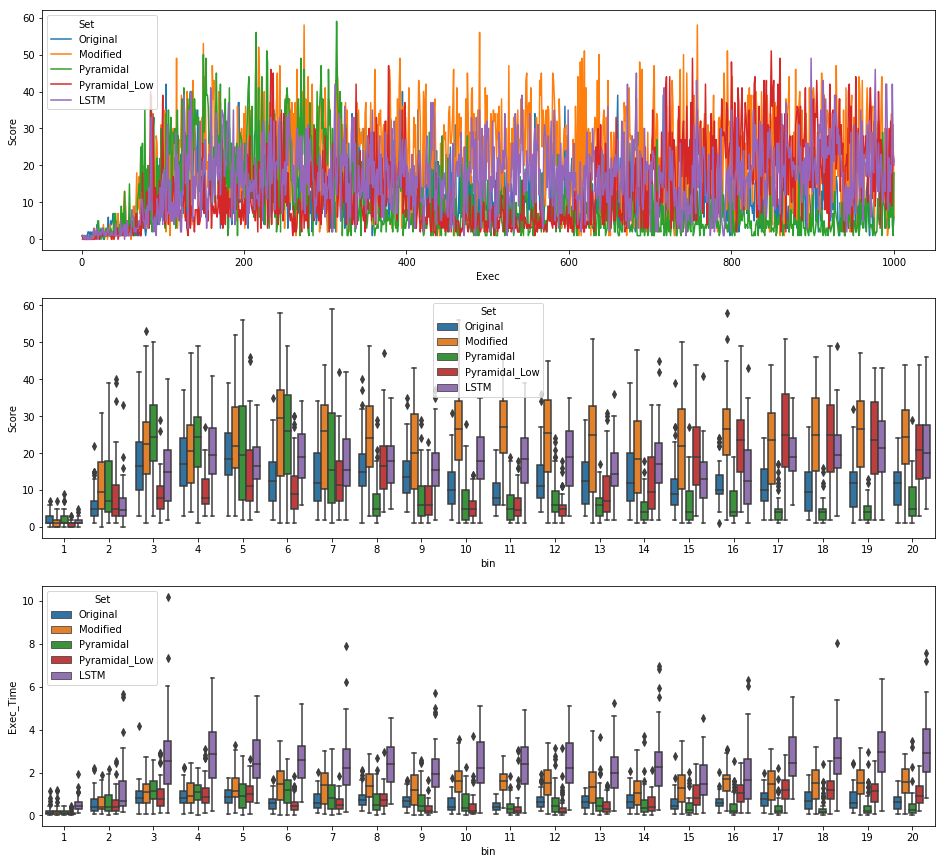

In [110]:
# Plot
plt.figure(figsize=(16, 15))
plt.subplot(3, 1, 1)
sns.lineplot(x='Exec', y='Score', hue='Set', data=results_df)
plt.subplot(3, 1, 2)
sns.boxplot(x='bin', y='Score', hue='Set', data=results_df)
plt.subplot(3, 1, 3)
sns.boxplot(x='bin', y='Exec_Time', hue='Set', data=results_df)

In [103]:
# Total execution times
results_df.groupby('Set')['Exec_Time'].sum()

Set
LSTM             2336.848762
Modified         1288.135543
Original          674.314771
Pyramidal         645.041266
Pyramidal_Low     735.720342
Name: Exec_Time, dtype: float64

### 4.4 Observaciones y conclusiones

**Observaciones:**
1. Modelo `Original`:
    * Aprende adecuadamente a jugar en poco tiempo.
    * Mantiene su media de puntuación a lo largo de las ejecuciones tardías en torno a los 15 puntos.
2. Modelo `Modified`:
    * Aprende adecuadamente a jugar en poco tiempo.
    * Alcanza las mejores puntuaciones de media aunque no consiga el record de los modelos.
    * Mantiene su capacidad de jugar adecuadamente a lo largo de todas las ejecuciones.
3. Modelo `Pyramid`:
    * Aprende rápidamente a jugar bien.
    * Alcanza el record de los modelos antes de las 500 ejecuciones.
    * Rápidamente se sobre-entrena y baja sus puntuaciones a la peor.
4. Modelo `Pyramid_Low`:
    * Aprende lentamente a jugar bien.
    * El ajuste de `dropout`consigue que el modelo no pierda su capacidad de juego pero evita que alcance las puntuaciones altas que consigue el modelo `Pyramid`.
    * Está entre las mejores puntuaciones una vez entrenado.
    * Requiere menos tiempo de ejecución que el modelo `Modified`.
5. Modelo `LSTM`:
    * Aprende lentamente a jugar.
    * Alcanza buenas medias en las etapas finales.
    * Necesita demasiado tiempo para ser ejecutado.

De estas observaciones podemos obtener las siguientes **conclusiones:**

* Los mejores modelos para este juego son el modelo `Modified`y el `Pyramid_Low`.
    * El modelo `Modified` aprende más rápido.
    * El modelo `Pyramid_Low` necesita más tiempo de entrenamiento pero menos tiempo de ejecución.
* El modelo `Pyramid`es un gran candidato pero habría que detectar el momento en el que se produce el sobre-entrenamiento para mantenerlo en unas cotas de acierto adecuadas.
* El modelo LSTM demuestra aprender adecuadamente a jugar aunque necesita demasiado tiempo de ejecución y entrenamiento.

## 5. Trabajos futuros

Observados estos resultados, los trabajos futuros podrían ser:
* Re-ejecutar los modelos `Pyramid_Low`y `Modified`con un grid parámetros centrados en los `dropout`y el ratio de aprendizaje.
* Re-ejecutar todos los modelos modificando las reglas del juego para que la serpiente pueda atravesar las paredes.